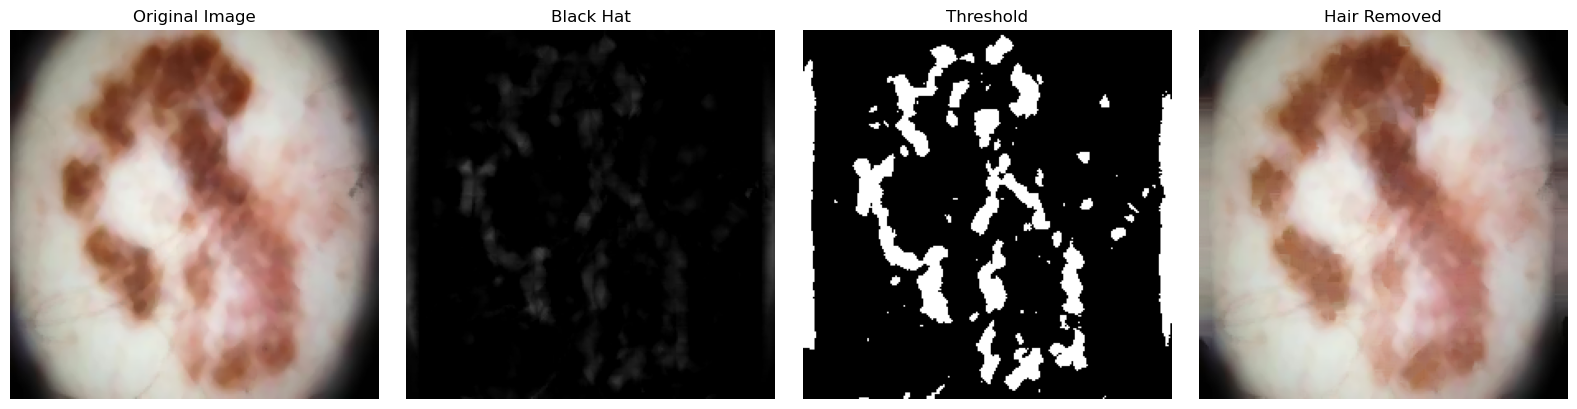

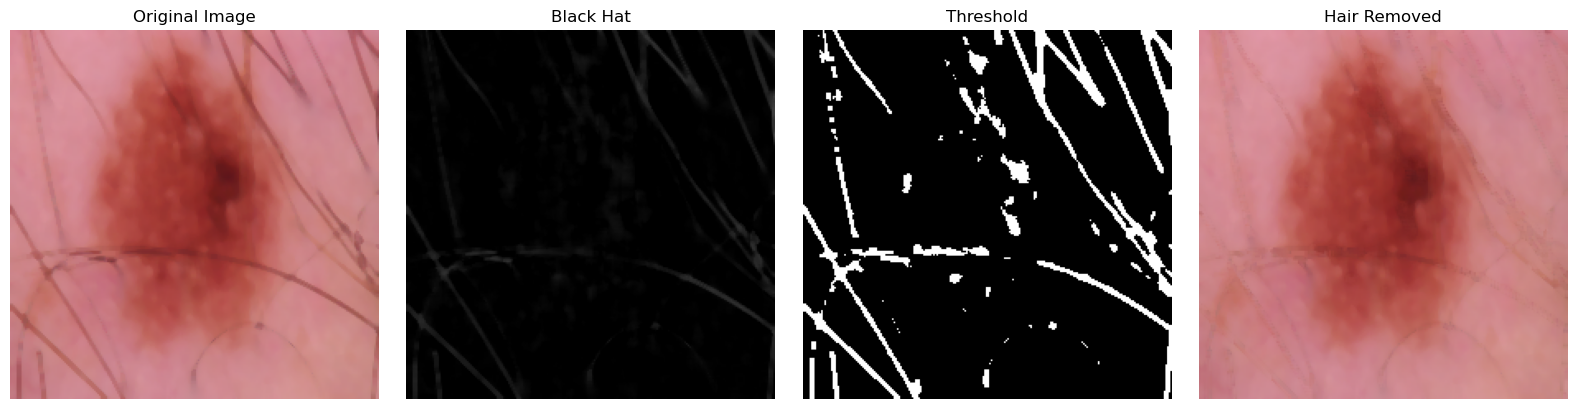

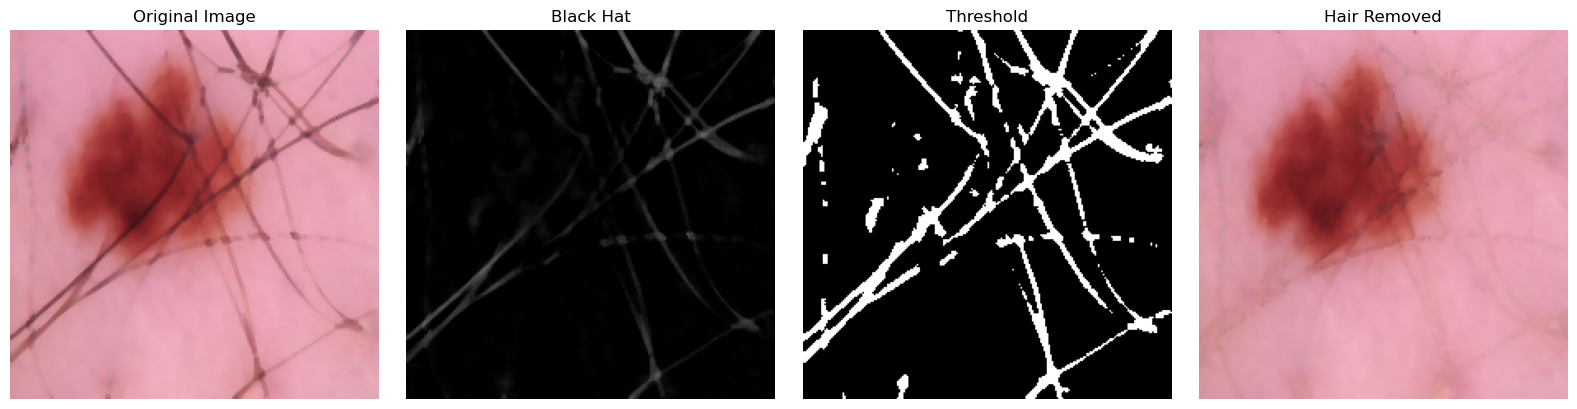

In [1]:
import cv2
from util import plot_images
from preprocessing import hair_removal, get_mask_dark_corners
import numpy as np
%load_ext autoreload
%autoreload 2


# Read the input image
image_1 = cv2.imread('./data/raw/test/malignant/44.jpg')
image_2 = cv2.imread('./data/raw/test/benign/998.jpg')
image_3 = cv2.imread("./data/raw/test/benign/303.jpg")


# Convert the image to grayscale (optional, depending on your needs)

# Apply a median filter with a specified kernel size
kernel_size = 5  # You can adjust this parameter based on the level of noise in your image
image_1_median_filtered_image = cv2.medianBlur(image_1, kernel_size)
image_2_median_filtered_image = cv2.medianBlur(image_2, kernel_size)
image_3_median_filtered_image = cv2.medianBlur(image_3, kernel_size)

image_1_removed_hair = hair_removal(image_1_median_filtered_image, debug=True)
image_2_removed_hair = hair_removal(image_2_median_filtered_image, debug=True)
image_3_removed_hair = hair_removal(image_3_median_filtered_image, debug=True)




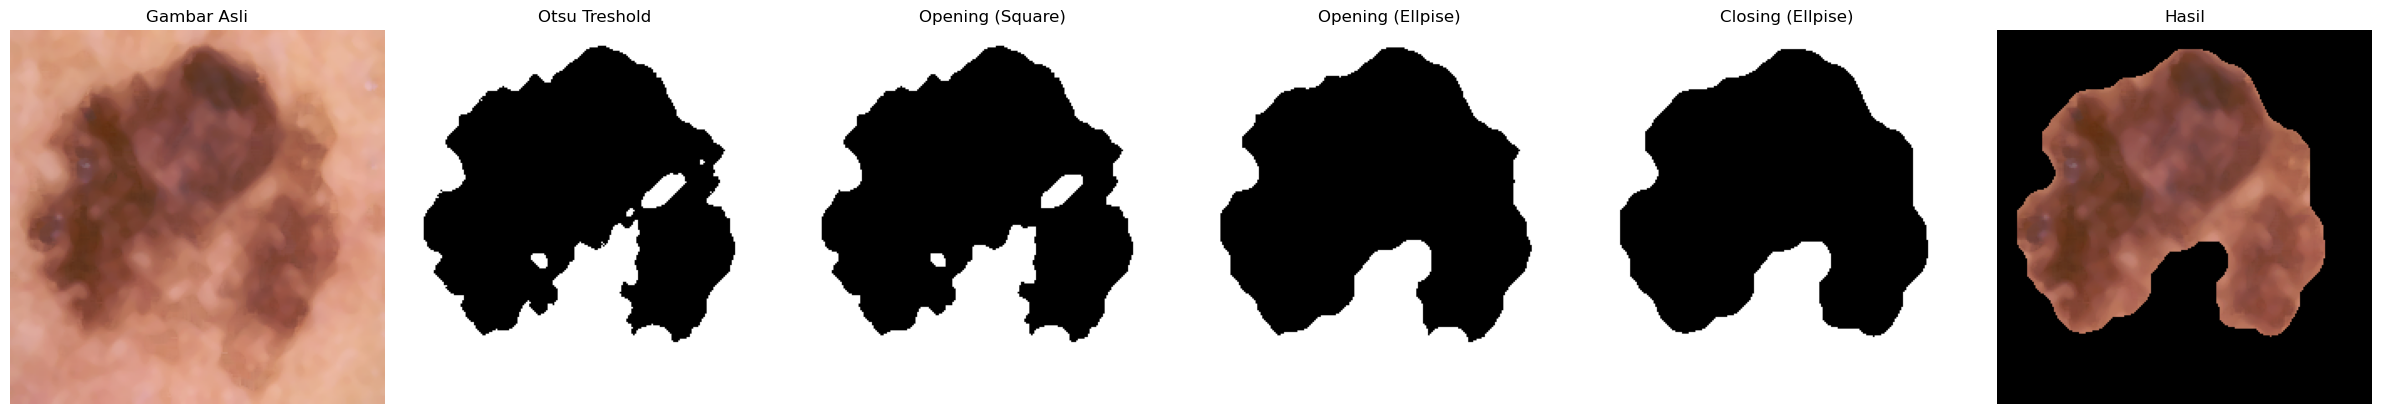

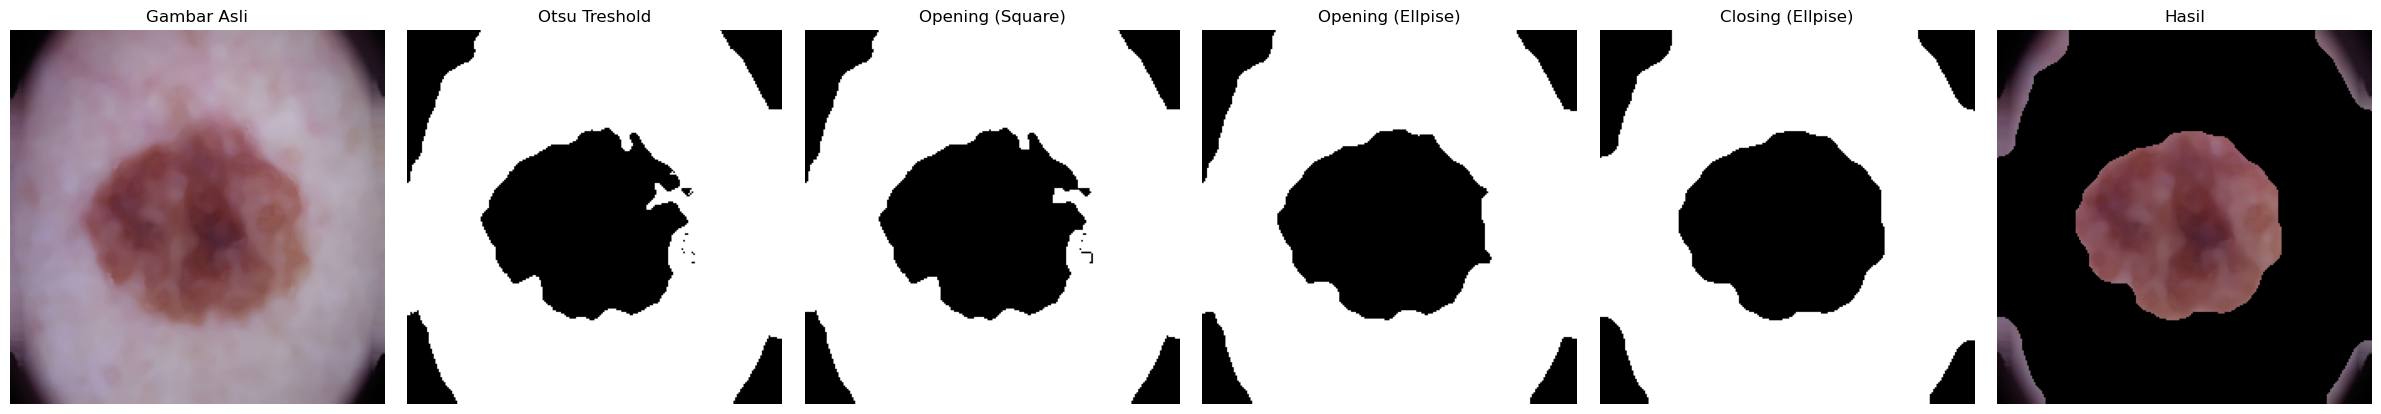

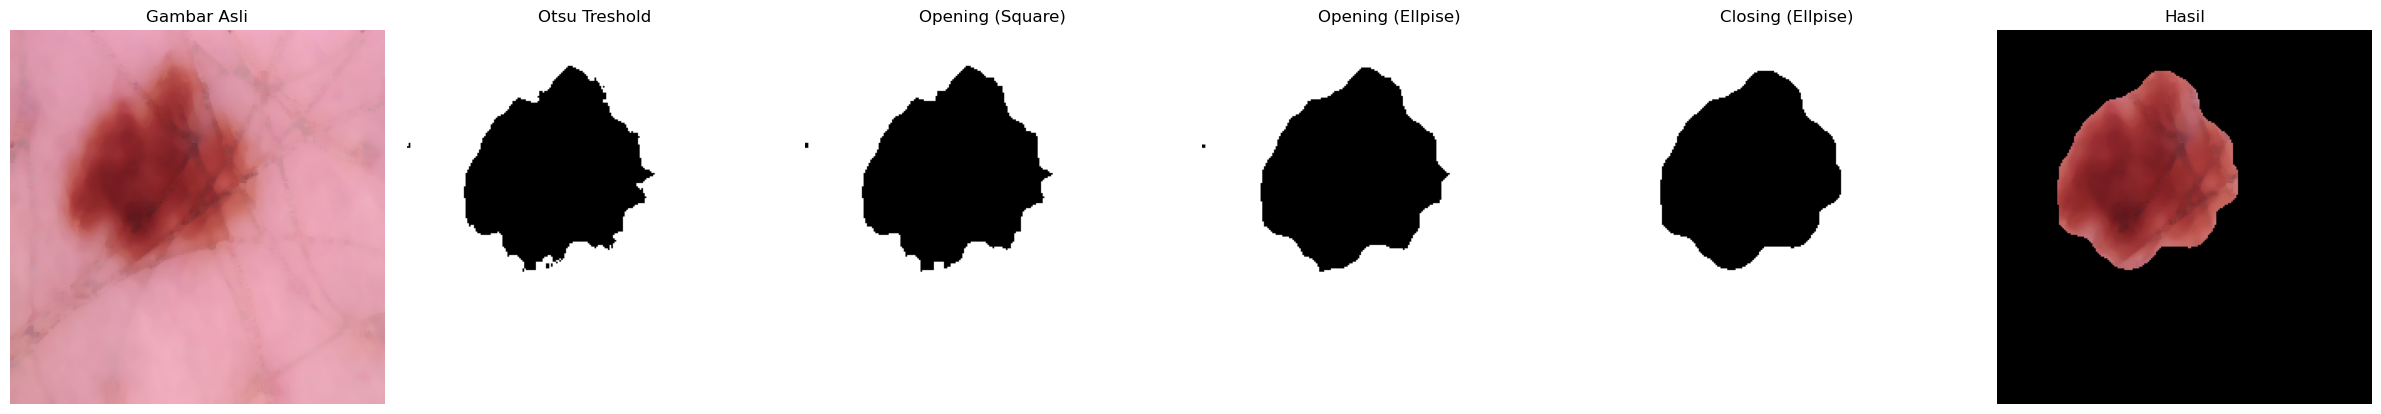

In [13]:
import cv2
import numpy as np
from preprocessing import preprocess_image

# Read the original image
image_1 = cv2.imread('./data/raw/train/malignant/975.jpg')
image_2 = cv2.imread('./data/raw/train/malignant/1476.jpg')
image_3 = cv2.imread("./data/raw/test/benign/303.jpg")


result_1 = preprocess_image(image_1, debug=True)
result_2 = preprocess_image(image_2, debug=True)
result_3 = preprocess_image(image_3, debug=True)
